# Potential Talents
---
## Summary
**Background:**

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

**Data Description**

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
- id : unique identifier for candidate (numeric)
- job_title : job title for candidate (text)
- location : geographical location for candidate (text)
- connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
- fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

**Goal(s):**

- Predict how fit the candidate is based on their available information (variable fit)

**Success Metric(s):**

- Rank candidates based on a fitness score.
- Re-rank candidates when a candidate is starred.

**Bonus(es):**

- We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
- How can we filter out candidates which in the first place should not be in this list?
- Can we determine a cut-off point that would work for other roles without losing high potential candidates?
- Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

# Exploratory Data Analysis

## Import Libraries

In [1]:
# Standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats

# for doc2vec
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

# for cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
# If running for the first time, download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import MinMaxScaler

# for BERT
from transformers import BertTokenizer, BertModel
import torch

# for ranking algorithm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [2]:
# Load the data from a CSV file
dataset = pd.read_csv('potential-talents.csv')

# Extract only 2 feature columns
x = dataset.iloc[:, [0,1,3]].values
y = dataset.iloc[:, 4].values

# Create a DataFrame with the feature columns
df = pd.DataFrame(x, columns=['id','job_title', 'connection'])

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (104, 3)
y shape: (104,)


# Data Preprocessing

## Missing Data

In [3]:
# Handle missing data
missing_data = dataset.isnull().sum()
print("Missing Data:")
print(missing_data)

# Impute missing values
#imputer = SimpleImputer(strategy='mean')  # Use mean imputation for numeric features
#dataset[numeric_features] = imputer.fit_transform(dataset[numeric_features])

Missing Data:
id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64


## Deduplicate

In [4]:
# Print the shape of the DataFrame before removing duplicates
print(f"Shape of the DataFrame before removing duplicates: {df.shape}")

# Remove duplicates and print the shape of the DataFrame after removing duplicates
df = df.drop_duplicates(subset=['job_title', 'connection'])
print(f"Shape of the DataFrame after removing duplicates: {df.shape}")

# Reset the index and print a success message
df = df.reset_index(drop=True)
print("Index reset after removing duplicates.")


Shape of the DataFrame before removing duplicates: (104, 3)
Shape of the DataFrame after removing duplicates: (53, 3)
Index reset after removing duplicates.


## Cleaning



### job_title

In [5]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define preprocesser
def preprocess(document):

    document = document.lower() # Convert text to lower case
    document = re.sub(r'\d+', '', document) # Remove numbers
    document = re.sub(r'\W', ' ', document) # Remove punctuation
    document = document.strip() # Remove leading/trailing white space

    tokens = nltk.word_tokenize(document) # Tokenize into words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords

    # Lemmatize or stem the words
    # For lemmatization:
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # For stemming:
    # tokens = [stemmer.stem(word) for word in tokens]

    document = " ".join(tokens) # Join the processed words back into a single string

    return document

In [6]:
# Clean columns
df['job_title'] = df['job_title'].apply(preprocess)

# Preprocess the words before getting their vectors
w1 = preprocess("Aspiring human resources")
w2 = preprocess("seeking human resources")

print(f"w1 becomes: {w1}")
print(f"w2 becomes: {w2}")

w1 becomes: aspiring human resource
w2 becomes: seeking human resource


### connection

In [7]:
# Make the "connection" column as a numeric column by making "500+" to "500" and leaving the rest
df['connection'] = df['connection'].replace('500+ ', '500').astype(int)
df['connection'] = df['connection'].replace('500+', '500').astype(int)


In [8]:
# Scale the "connection" column

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the 'connections' column
df['connection_scaled'] = scaler.fit_transform(df[['connection']])

# Natural Language Processing

## Doc2Vec

In [9]:
# Create doc2vec embeddings for all job titles, and w1 (chosen phrases)

# Tokenize the job_titles
data = [word_tokenize(title) for title in df['job_title']]

# Create tagged documents
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data)]

# Set-up the model
model = Doc2Vec(vector_size=20,      # Dimensionality of the feature vectors
                window=2,            # The maximum distance between the current and predicted word within a sentence.
                min_count=1,         # Ignores all words with total frequency lower than this.
                workers=4,           # Use these many worker threads to train the model
                epochs=100)          # Number of iterations (epochs) over the corpus

# Build vocabulary from a sequence of sentences
model.build_vocab(tagged_data)

# Train the model
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# Extract vectors of all job_titles
vectors = [model.dv[i] for i in range(len(df['job_title']))]

# now 'vectors' contains the doc2vec vectors for each job_title

df['doc2vec_embeddings'] = vectors

# Infer the vector for each chosen phrase
v1 = model.infer_vector(word_tokenize(w1))
v2 = model.infer_vector(word_tokenize(w2))

In [10]:
# Calculate Cosine Similarity between w1 and each job_title

# Initialize an empty list to store the similarities
similarities = []

# Loop through each job title vector
for vec in vectors:
    # Reshape vectors to 2D arrays necessary for cosine_similarity function
    vec = np.array(vec).reshape(1, -1)
    v1 = np.array(v1).reshape(1, -1)

    # Calculate similarity and append to the list
    sim = cosine_similarity(vec, v1)
    similarities.append(sim[0][0])

# Now 'similarities' is a list of cosine similarities between 'w1' and each job title.

# Add the 'similarities' list as a new column to the dataframe
df['similarity'] = similarities

print(f"Size of Similarities: {len(similarities)}")

Size of Similarities: 53


## BERT
(Bidirectional Encoder Representations from Transformers)

In [11]:
# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings
def generate_bert_embeddings(text):
    # Add the special tokens for BERT
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indices.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Mark each token as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    model.eval()

    # Predict hidden states features for each layer
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # `outputs` is a tuple, we only need the token embeddings from the first element of the tuple
        encoded_layers = outputs[0]

    # Get the embeddings of the [CLS] token as the text embedding
    text_embedding = encoded_layers[0][0]

    return text_embedding.numpy()  # Convert tensor to numpy array for easier use

# Generate BERT embeddings for all job titles and store in a list
bert_embeddings = df['job_title'].apply(generate_bert_embeddings).tolist()

df['bert_embeddings'] = bert_embeddings

# Generate BERT embedding for each chosen phrase
w1_bert = generate_bert_embeddings(w1)
w2_bert = generate_bert_embeddings(w2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Initialize an empty list to store the similarities
bert_similarities = []

# Loop through each BERT job title vector
for bert_vec in bert_embeddings:
    # Reshape vectors to 2D arrays necessary for cosine_similarity function
    bert_vec = np.array(bert_vec).reshape(1, -1)
    w1_bert = np.array(w1_bert).reshape(1, -1)

    # Calculate similarity and append to the list
    sim = cosine_similarity(bert_vec, w1_bert)
    bert_similarities.append(sim[0][0])

# Now 'bert_similarities' is a list of cosine similarities between 'w1' and each job title

# Add the 'similarities' list as a new column to the dataframe
df['bert_similarity'] = bert_similarities

print(f"Size of bert_Similarities: {len(bert_similarities)}")

Size of bert_Similarities: 53


## Weighted Sum

In [13]:
# Set weights here
weight_similarity = 0.8
weight_connection = 0.2

# Ensure weights add up to 1
assert weight_similarity + weight_connection == 1, "Weights should add up to 1"

# Create the weighted sum column
df['ranking'] = weight_similarity * df['similarity'] + weight_connection * df['connection_scaled']


In [14]:
# Set BERT weights here
weight_similarity_bert = 0.8
weight_connection = 0.2

# Ensure weights add up to 1
assert weight_similarity_bert + weight_connection == 1, "Weights should add up to 1"

# Create the weighted sum column
df['bert_ranking'] = weight_similarity_bert * df['bert_similarity'] + weight_connection * df['connection_scaled']

# Initial Ranking

The candidates are sorted according to their Doc2Vec and BERT ranking. Then, the top 10 for BERT are starred, and used as the target variable for binary classification in the next section.

In [15]:
# Sorting by Doc2Vec ranking
doc2vec_ranking = df.sort_values('ranking', ascending=False)

# Sorting by BERT ranking
bert_ranking = df.sort_values('bert_ranking', ascending=False)

# Select specific columns
doc2vec_ranking = doc2vec_ranking[['id', 'job_title', 'ranking']]
bert_ranking = bert_ranking[['id', 'job_title', 'bert_ranking']]

# Print top 10 
print("Top 10 rankings based on Doc2Vec:\n")
print(doc2vec_ranking.head(10).to_string(index=False))
print("\nTop 10 rankings based on BERT:\n")
print(bert_ranking.head(10).to_string(index=False))

# Get the IDs of top 10 candidates based on BERT rankings
top10_bert_ids = bert_ranking['id'].head(10).values

# Create a new 'starred' column, initially setting all values to False
df['starred'] = 0

# Set 'starred' to True for top 10 candidates
df.loc[df['id'].isin(top10_bert_ids), 'starred'] = 1


Top 10 rankings based on Doc2Vec:

 id                                                                  job_title  ranking
 27              aspiring human resource management student seeking internship 0.861826
 71                                  human resource generalist scottmadden inc 0.844028
  4                                        people development coordinator ryan 0.843805
 85              rrp brand portfolio executive jti japan tobacco international 0.837965
  5                               advisory board member celal bayar university 0.834238
 75 nortia staffing seeking human resource payroll administrative professional 0.829047
  2                          native english teacher epik english program korea 0.828274
 10                            seeking human resource hris generalist position 0.827193
103                                                         always set success 0.825973
 67                            human resource staffing recruiting professional 0.8254

# LambdaRank

In [16]:
X = df[['similarity', 'bert_similarity', 'connection_scaled']]
Y = df['starred']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2,
                                                  random_state=21, stratify=Y)

# Define the ranking metric (NDCG) and the LambdaRank model


def ndcg(y_true, y_pred):
    return 'ndcg', ndcg_score([y_true], [y_pred]), True


lambdarank_model = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31,
                                  learning_rate=0.01,
                                  n_estimators=100, min_child_samples=2,
                                  subsample=1, colsample_bytree=1.0,
                                  eval_metric='ndcg',
                                  objective='binary', sigmoid='1.0')

query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]

# Train the LambdaRank model
lambdarank_model.fit(X_train, y_train, group=query_train,
                     eval_set=[(X_val, y_val)], eval_group=[query_val], eval_metric=ndcg, verbose = -1)

[LightGBM] [Warning] Unknown parameter: eval_metric


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(eval_metric='ndcg', learning_rate=0.01, min_child_samples=2,
           objective='binary', sigmoid='1.0', subsample=1)

## Results

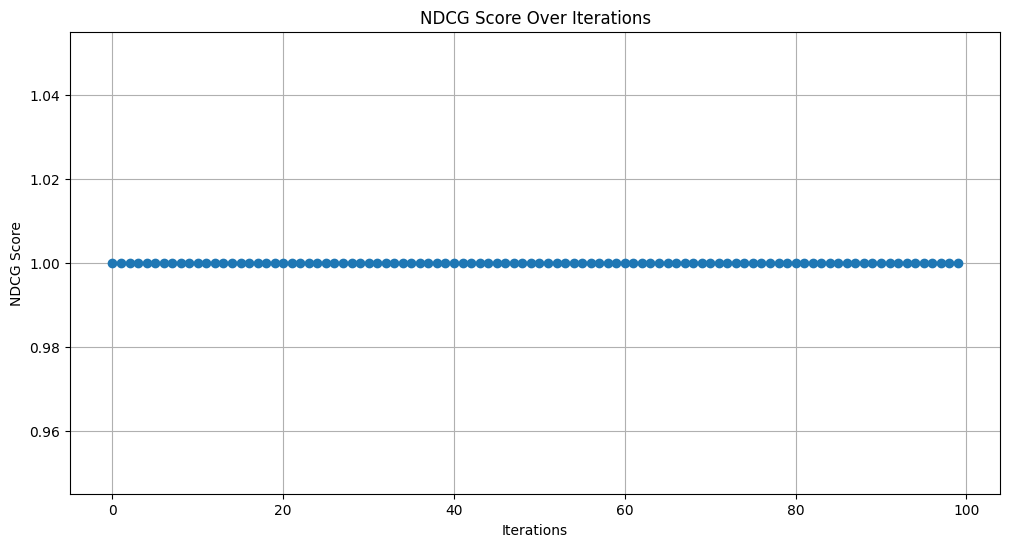

In [17]:
# Retrieve evaluation results
evals_result = lambdarank_model.evals_result_

# Extract NDCG scores
ndcg_scores = evals_result['valid_0']['ndcg']

plt.figure(figsize=(12, 6))
plt.plot(ndcg_scores, marker='o')
plt.title('NDCG Score Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.grid(True)
plt.show()


## Feature Importance

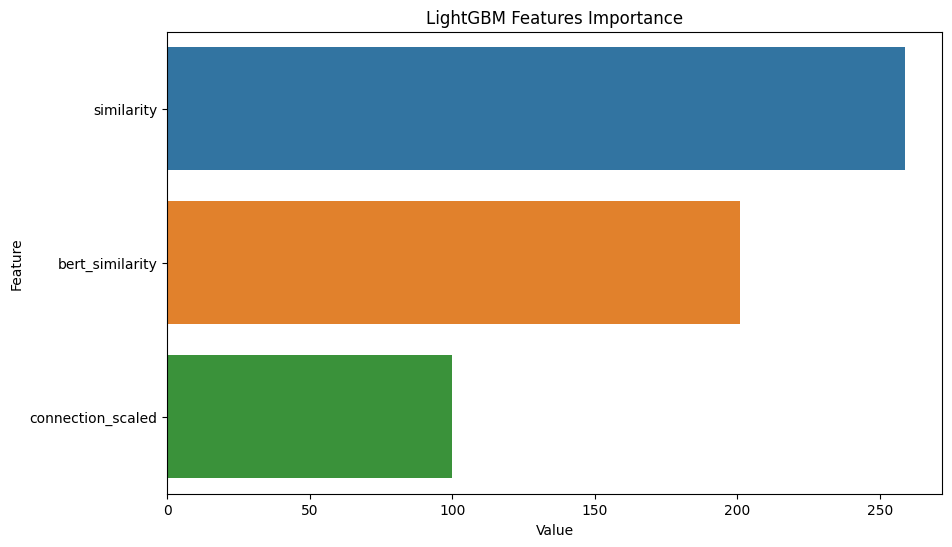

In [18]:
feature_imp = pd.DataFrame(sorted(zip(lambdarank_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.show()

## Validation

Rerank the candidates now that they are starred.

In [20]:
# Prepare features
candidates = df[['similarity', 'bert_similarity', 'connection_scaled']]

# Predict scores
scores = lambdarank_model.predict(candidates)
df['predicted_scores'] = scores

# Sort
reranked_candidates = df.sort_values(by='predicted_scores', ascending=False)

# Print top 10
reranked_candidates = reranked_candidates[['id', 'job_title', 'starred', 'predicted_scores']]
print(reranked_candidates.head(10).to_string(index=False))


 id                                                                  job_title  starred  predicted_scores
 68                                        human resource specialist luxottica        1          0.719926
 67                            human resource staffing recruiting professional        1          0.704149
 27              aspiring human resource management student seeking internship        1          0.704149
104                                 director administration excellence logging        1          0.703610
 75 nortia staffing seeking human resource payroll administrative professional        1          0.703610
  4                                        people development coordinator ryan        1          0.703610
 71                                  human resource generalist scottmadden inc        1          0.703610
 13               human resource coordinator intercontinental buckhead atlanta        0          0.590706
101                                          h

# Summary

**Goal(s):**

- Predict how fit the candidate is based on their available information (variable fit)
    - Completed

**Success Metric(s):**

- Rank candidates based on a fitness score.
    - Completed in the 'Initial Ranking' section.
- Re-rank candidates when a candidate is starred.
    - Completed in the 'LambdaRank Validation' section above.

**Bonus(es):**

- We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
    - The solution uses a machine learning model called LambdaRank, which is a pairwise ranking algorithm. It is designed to optimize the ranking of a list of items based on some features and a target relevance score. In our case, we've used features like similarity scores from two NLP models and connection strength, and the relevance score is indicated by whether a candidate is 'starred' or not.
    - Each time a new candidate is 'starred', we are essentially providing the model with a new piece of information about what kind of candidates should be ranked higher. This additional info can help improve the model's understanding and hence its ranking performance. As we gather more and more 'starred' candidates, our model gets better and better at ranking future candidates.
- How can we filter out candidates which in the first place should not be in this list?
    - Using the Similarity score (either Doc2Vec or BERT), we can set a threshold value (ex. 0.20) where anything below that value is considered 'not relevant', and can be safely removed from the list. The threshold value can be set manually at first by simply observing where the job titles begin to appear to be irrelevant to the goal.
- Can we determine a cut-off point that would work for other roles without losing high potential candidates?
    - In general, a cut-off point might work well for other roles if the pool of candidates and the role type are similar. But if they are different, it is safer to determine a new cut-off point for each role. You could simply select the bottom 10% as a cut-off, but such a broad move risks losing high-potential candidates.
- Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?
    - The process as shown here can be automated by simply adjusting the input of new data. More practical considerations would be regarding the 'starring' process. 'Starring' should be based on objective criteria - if the 'starring' action is biased (ex. if it only favours a certain type of candidate), the model will learn and replicate this bias.